In [1]:
import os

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
csv_dir = '../my-data'
dfs_1, dfs_2 = [], []
for csv in os.listdir(csv_dir):
    df = pd.read_csv(os.path.join(csv_dir, csv), index_col=0, dtype=float)
    df.drop(columns=["0.5"], inplace=True)
    if csv.endswith('1.csv'):
        dfs_1.append(df)
    elif csv.endswith('2.csv'):
        dfs_2.append(df)

chiller_temps = [pd.concat(dfs) for dfs in zip(dfs_1, dfs_2)]
df_concat = pd.concat(chiller_temps)
df_grouped = df_concat.groupby(df_concat.index)
avg_temp = df_grouped.mean()
avg_temp.drop(index=[210.0, 240.0, 270.0, 300.0, 330.0], inplace=True)
avg_temp.head(13)

,1.25,2.0,2.75,3.5,4.25,5.0,5.75,6.5,7.25
0.0,1.360195,1.303995,1.906685,2.800230,3.331275,4.389140,5.096230,5.120160,5.192810
30.0,1.243320,2.047050,2.623735,2.867975,2.898135,3.044935,3.667295,4.119930,4.673945
60.0,2.101070,2.290080,2.798130,3.093140,3.340425,3.388685,3.614315,4.015890,4.392805
90.0,1.531960,1.745265,1.866900,2.135470,2.318210,2.345640,2.346175,2.316240,2.505455
120.0,1.898960,2.623795,3.038300,3.067085,3.002945,2.915115,2.791730,2.651570,2.513745
150.0,1.658845,2.332325,2.845960,2.949025,2.898245,2.760440,2.587580,2.448930,2.318640
180.0,1.661300,2.186055,2.747570,2.866275,2.688655,2.466415,2.270890,2.071465,1.916750


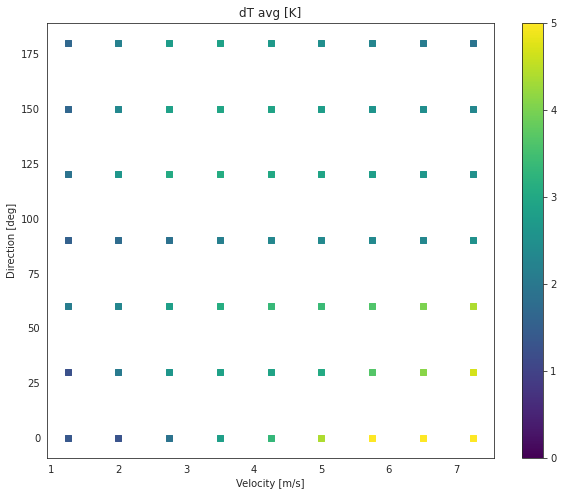

In [4]:
X1_obs = [float(i) for i in avg_temp.columns.tolist()]
X2_obs = [float(i) for i in avg_temp.index.tolist()]
x1, x2 = np.meshgrid(X1_obs, X2_obs)
x11 = sum(x1.tolist(), [])
x22 = sum(x2.tolist(), [])

y_obs = sum(avg_temp.values.tolist(), [])

with sns.axes_style("white"):
    plt.figure(figsize=(10,8))
    plt.scatter(x11, x22, c=y_obs, marker='s', cmap=plt.cm.viridis, vmin=0, vmax=5)
    plt.xlabel("Velocity [m/s]")
    plt.ylabel("Direction [deg]")
    plt.title("dT avg [K]")
    plt.colorbar()

Text(0.5, 118.5, 'Prędkość wiatru [m/s]')

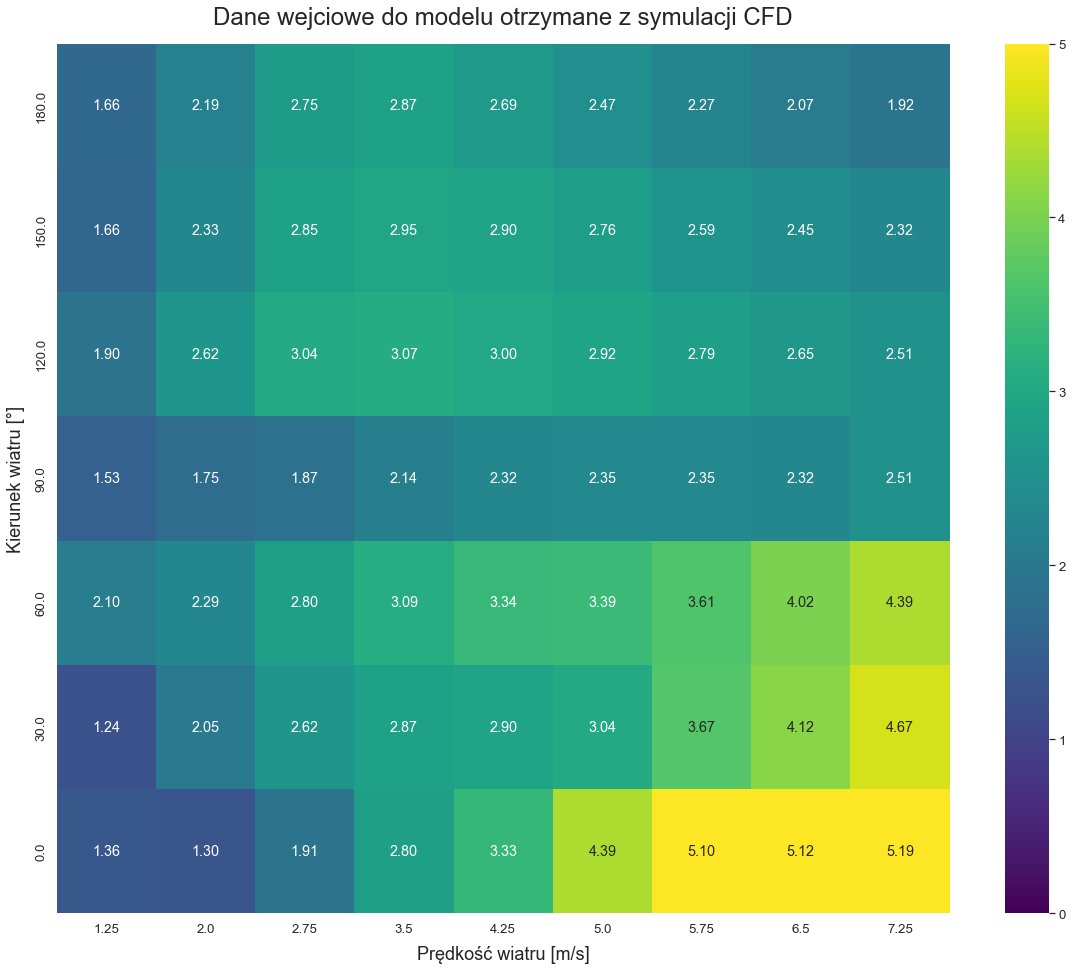

In [5]:
dT = np.reshape(y_obs, (len(X2_obs), len(X1_obs)))

plt.figure(figsize=(20,16))
sns.set(font_scale=1.2)
ax = sns.heatmap(dT, vmin=0, vmax=5, annot=True, fmt='.2f', cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(avg_temp.index)
ax.set_xticklabels(avg_temp.columns)
ax.set_title('Dane wejciowe do modelu otrzymane z symulacji CFD', fontsize=24, y=1.015)
ax.set_ylabel('Kierunek wiatru [\N{DEGREE SIGN}]', fontsize=18, labelpad=10)
ax.set_xlabel('Prędkość wiatru [m/s]', fontsize=18, labelpad=10)

In [6]:
X_obs = np.concatenate([x1.reshape(len(x1)*len(x1[0]), 1), x2.reshape(len(x2)*len(x2[0]), 1)], axis=1)

In [7]:
RANDOM_SEED = 42
CHAINS = 4

In [8]:
with pm.Model() as polynomial_regression:
    X1 = np.asarray(x11)
    X2 = np.asarray(x22)
    
    y_obs_pm = pm.Data('y_obs_pm', y_obs)
    
    beta = pm.Normal('beta',0,20, shape=6)
    sigma = pm.HalfNormal('sigma',100)
    
    mu = beta[0] + beta[1]*X1 + beta[2]*X2 + beta[3]*X1**2 + beta[4]*X2**2 + beta[5]*X1*X2
    y_hat = pm.Normal('y_hat', mu, sigma, observed=y_obs)

In [9]:
with pm.Model() as gaussian_process:
    
    l1 = pm.Rice("ls", nu=3, sigma=1)
    l2 = pm.Rice("ld", nu=30, sigma=2)
    sf = pm.Rice("sf", nu=0, sigma=1)
    sn = pm.HalfNormal("sn", 0.17)

    M = pm.gp.mean.Zero()
    K = pm.gp.cov.ExpQuad(2, [l1, l2]) * sf**2
    
    gp_chillers = pm.gp.Marginal(mean_func=M, cov_func=K)
    obs = gp_chillers.marginal_likelihood("obs", X=X_obs, y=y_obs, noise=sn)

In [10]:
with polynomial_regression:
    pr_trace = pm.sample(1000, tune=2000, cores=8, chains=CHAINS, random_seed=RANDOM_SEED, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [sigma, beta]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 61 seconds.


In [11]:
with gaussian_process:
    gp_trace = pm.sample(1000, tune=2000, cores=8, chains=CHAINS, random_seed=RANDOM_SEED)

WARNING (theano.tensor.opt): Optimization Warning: The Op i0e does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.opt): Optimization Warning: The Op i1e does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [sn, sf, ld, ls]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 35 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


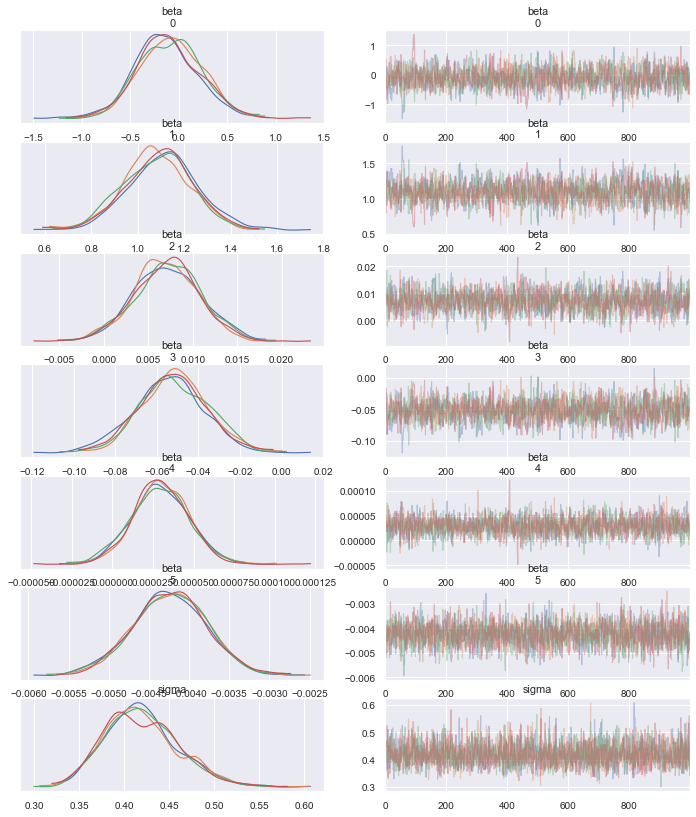

In [12]:
az.plot_trace(pr_trace, compact=False);

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


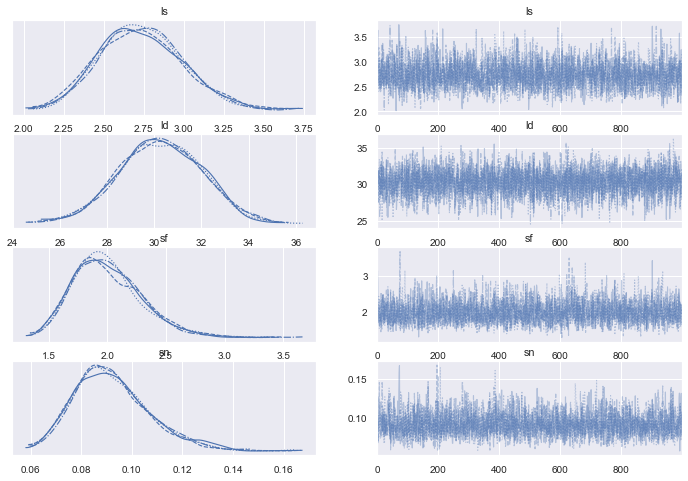

In [13]:
az.plot_trace(gp_trace, var_names=['ls', 'ld', 'sf', 'sn']);

Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'beta\n0'}>,
        <AxesSubplot:title={'center':'beta\n1'}>,
        <AxesSubplot:title={'center':'beta\n2'}>],
       [<AxesSubplot:title={'center':'beta\n3'}>,
        <AxesSubplot:title={'center':'beta\n4'}>,
        <AxesSubplot:title={'center':'beta\n5'}>],
       [<AxesSubplot:title={'center':'sigma'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

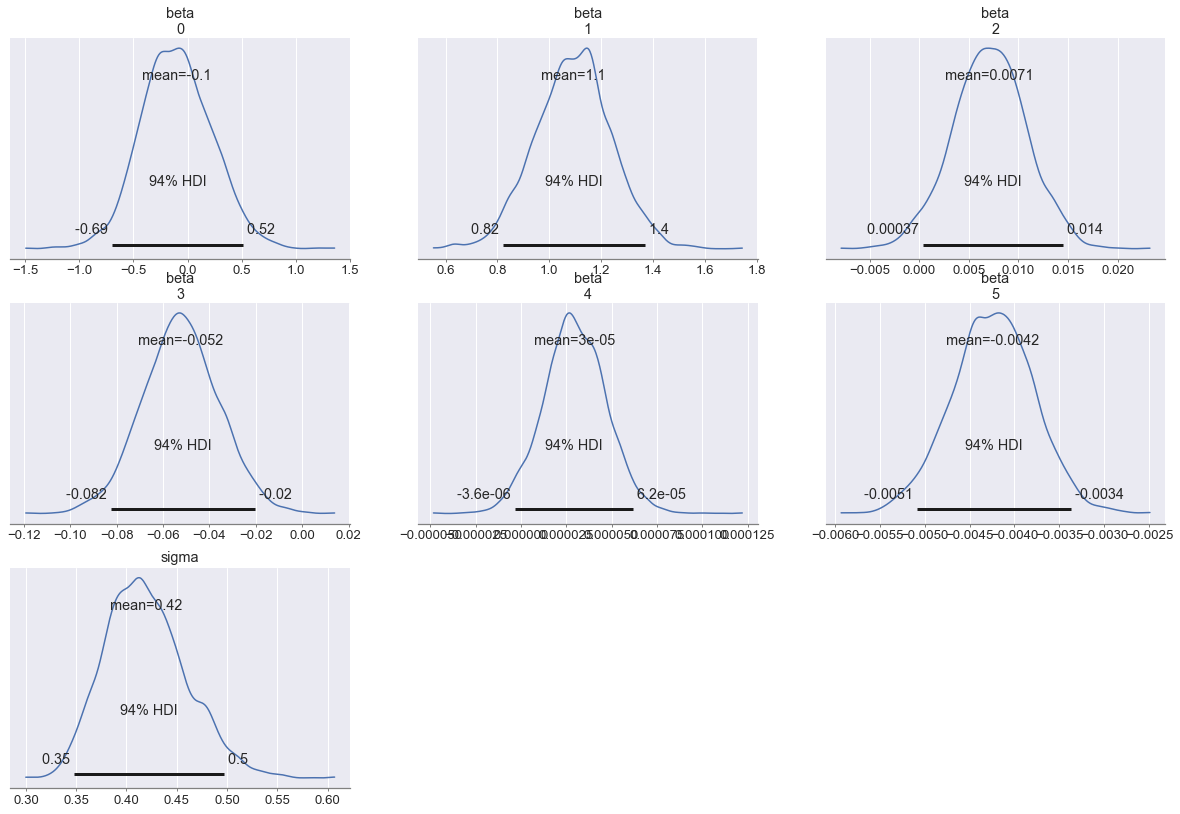

In [14]:
az.plot_posterior(pr_trace)

Got error No model on context stack. trying to find log_likelihood in translation.


array([<AxesSubplot:title={'center':'ls'}>,
       <AxesSubplot:title={'center':'ld'}>,
       <AxesSubplot:title={'center':'sf'}>,
       <AxesSubplot:title={'center':'sn'}>], dtype=object)

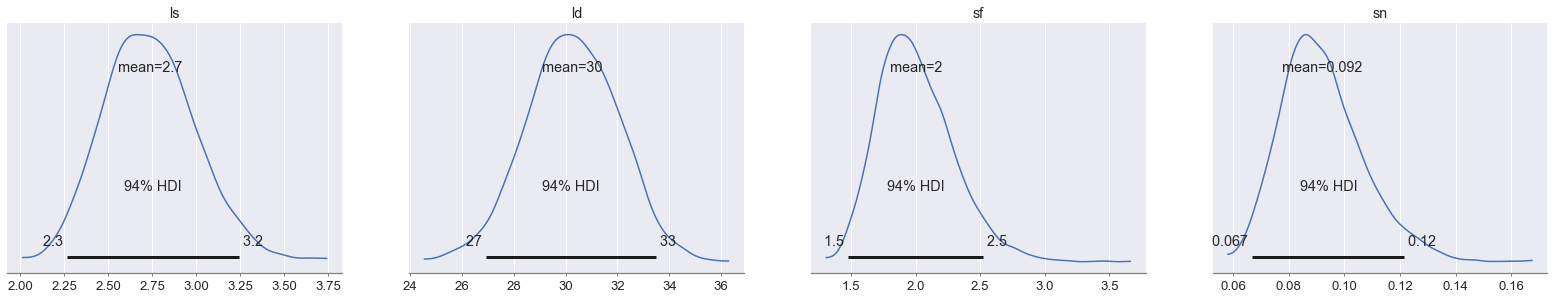

In [15]:
az.plot_posterior(gp_trace)

In [16]:
az.summary(pr_trace, round_to=3)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.103,0.329,-0.695,0.516,0.009,0.007,1252.899,1730.897,1.004
beta[1],1.092,0.147,0.821,1.369,0.004,0.003,1145.622,1430.851,1.006
beta[2],0.007,0.004,0.000,0.014,0.000,0.000,1520.457,1862.146,1.001
beta[3],-0.052,0.016,-0.082,-0.020,0.000,0.000,1265.940,1298.526,1.005
beta[4],0.000,0.000,-0.000,0.000,0.000,0.000,1872.183,2020.149,1.001
beta[5],-0.004,0.000,-0.005,-0.003,0.000,0.000,2138.494,2104.163,1.001
sigma,0.420,0.041,0.348,0.497,0.001,0.001,3017.372,2454.526,1.001


In [17]:
az.summary(gp_trace, round_to=3, var_names=['ls', 'ld', 'sf', 'sn'])

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ls,2.739,0.264,2.268,3.241,0.005,0.004,2804.141,2763.218,1.001
ld,30.258,1.760,26.944,33.471,0.027,0.019,4226.746,2964.254,1.000
sf,2.002,0.293,1.473,2.523,0.005,0.004,3190.407,2923.468,1.002
sn,0.092,0.015,0.067,0.122,0.000,0.000,2931.506,2646.997,1.001


In [18]:
loo_pr = az.loo(pr_trace, polynomial_regression)
loo_pr.loo

Got error No model on context stack. trying to find log_likelihood in translation.


-37.559247420030204

In [19]:
loo_gp = az.loo(gp_trace, gaussian_process)
loo_gp.loo

Got error No model on context stack. trying to find log_likelihood in translation.


-19.544547986739822

In [20]:
nv = 18
nd = 14
ws = np.linspace(0.5, 10, nv)
wd = np.linspace(10, 170, nd)
t1, t2 = np.meshgrid(ws, wd)
T = np.concatenate([t1.reshape(len(t1)*len(t1[0]), 1), t2.reshape(len(t2)*len(t2[0]), 1)], axis=1)

In [21]:
n_samples = 4000

smpl = []
for b0, b1, b2, b3, b4, b5 in pr_trace['beta'][:n_samples]:
    for d in wd:
        for s in ws:
            smpl.append(b0 + b1*s + b2*d + b3*s**2 + b4*d**2 + b5*s*d)
            
samples_pr = np.array(smpl)
samples_pr = samples_pr.reshape(n_samples,nv*nd)

In [22]:
with gaussian_process:

    f_pred = gp_chillers.conditional('f_pred', T)
    
    samples_gp = pm.sample_posterior_predictive([gp_trace], var_names=['f_pred'], random_seed=RANDOM_SEED, samples=100)

In [23]:
s_pr = samples_pr.mean(axis=0).reshape(nd,nv)
sd_pr = samples_pr.std(axis=0).reshape(nd,nv)

s_gp = samples_gp['f_pred'].mean(axis=0).reshape(nd, nv)
sd_gp = samples_gp['f_pred'].std(axis=0).reshape(nd, nv)

Text(0.5, 118.5, 'Prędkość wiatru [m/s]')

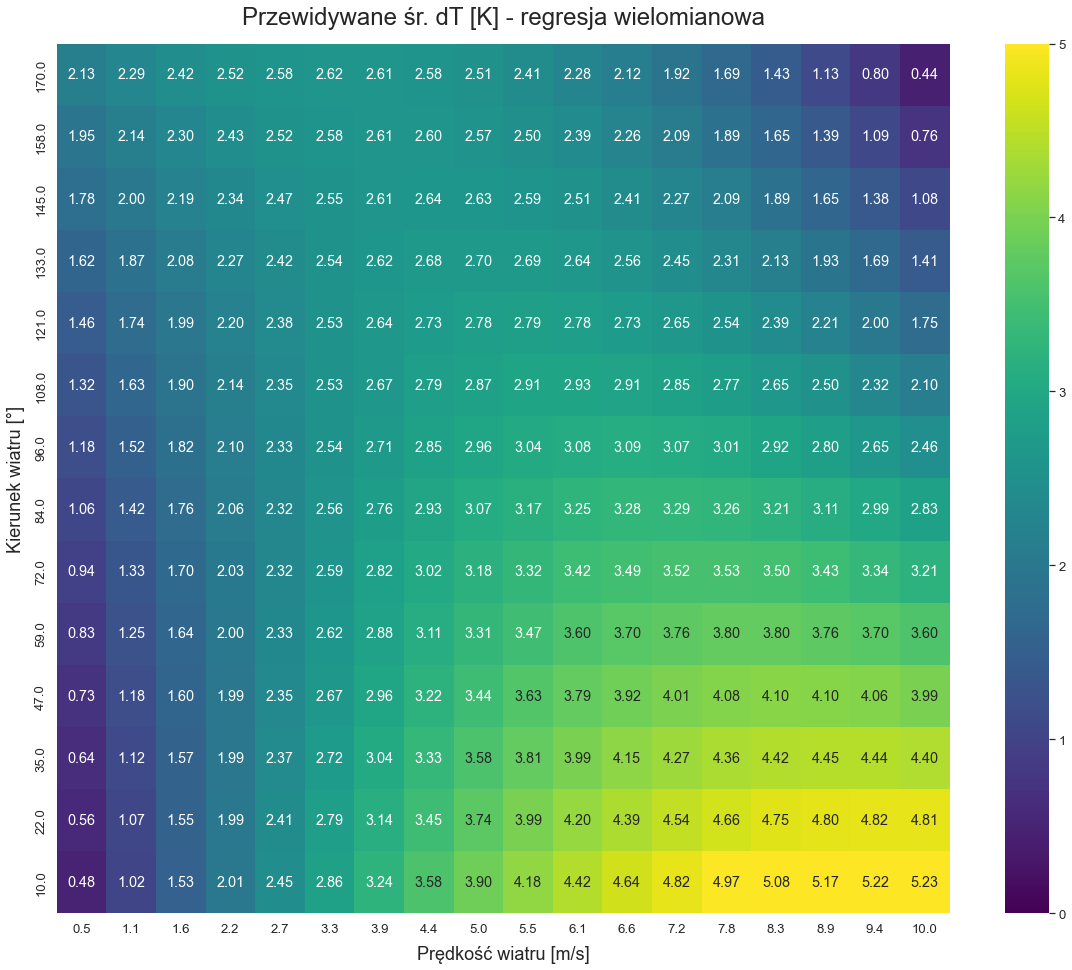

In [24]:
plt.figure(figsize=(20,16))
sns.set(font_scale=1.2)
ax = sns.heatmap(s_pr, vmin=0, vmax=5, annot=True, fmt='.2f', cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Przewidywane śr. dT [K] - regresja wielomianowa', fontsize=24, y=1.015)
ax.set_ylabel('Kierunek wiatru [\N{DEGREE SIGN}]', fontsize=18, labelpad=10)
ax.set_xlabel('Prędkość wiatru [m/s]', fontsize=18, labelpad=10)

Text(0.5, 118.5, 'Prędkość wiatru [m/s]')

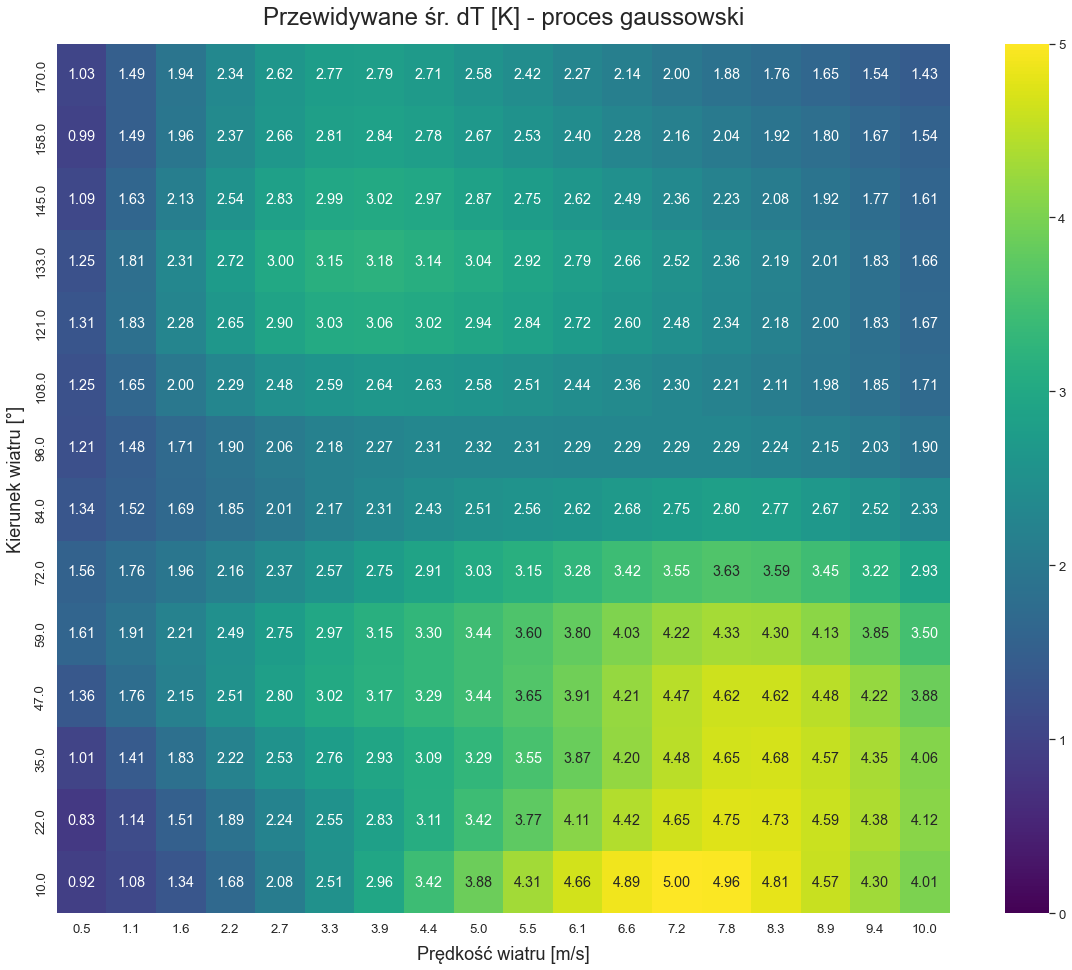

In [25]:
plt.figure(figsize=(20,16))
sns.set(font_scale=1.2)
ax = sns.heatmap(s_gp, vmin=0, vmax=5, annot=True, fmt='.2f', cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Przewidywane śr. dT [K] - proces gaussowski', fontsize=24, y=1.015)
ax.set_ylabel('Kierunek wiatru [\N{DEGREE SIGN}]', fontsize=18, labelpad=10)
ax.set_xlabel('Prędkość wiatru [m/s]', fontsize=18, labelpad=10)

Text(0.5, 118.5, 'Prędkość wiatru [m/s]')

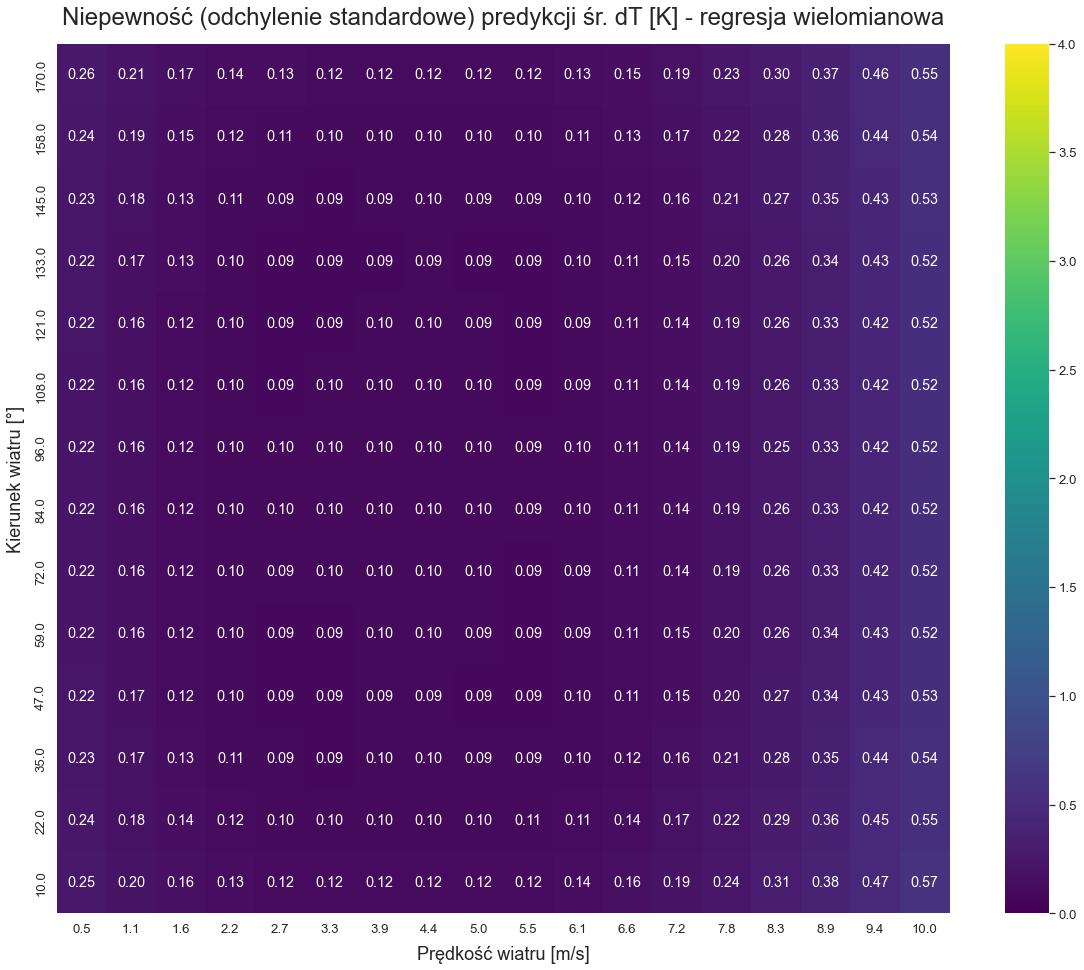

In [26]:
plt.figure(figsize=(20,16))
ax = sns.heatmap(sd_pr, vmin=0, vmax=4, annot=True, fmt='.2f', cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Niepewność (odchylenie standardowe) predykcji śr. dT [K] - regresja wielomianowa', fontsize=24, y=1.015)
ax.set_ylabel('Kierunek wiatru [\N{DEGREE SIGN}]', fontsize=18, labelpad=10)
ax.set_xlabel('Prędkość wiatru [m/s]', fontsize=18, labelpad=10)

Text(0.5, 118.5, 'Prędkość wiatru [m/s]')

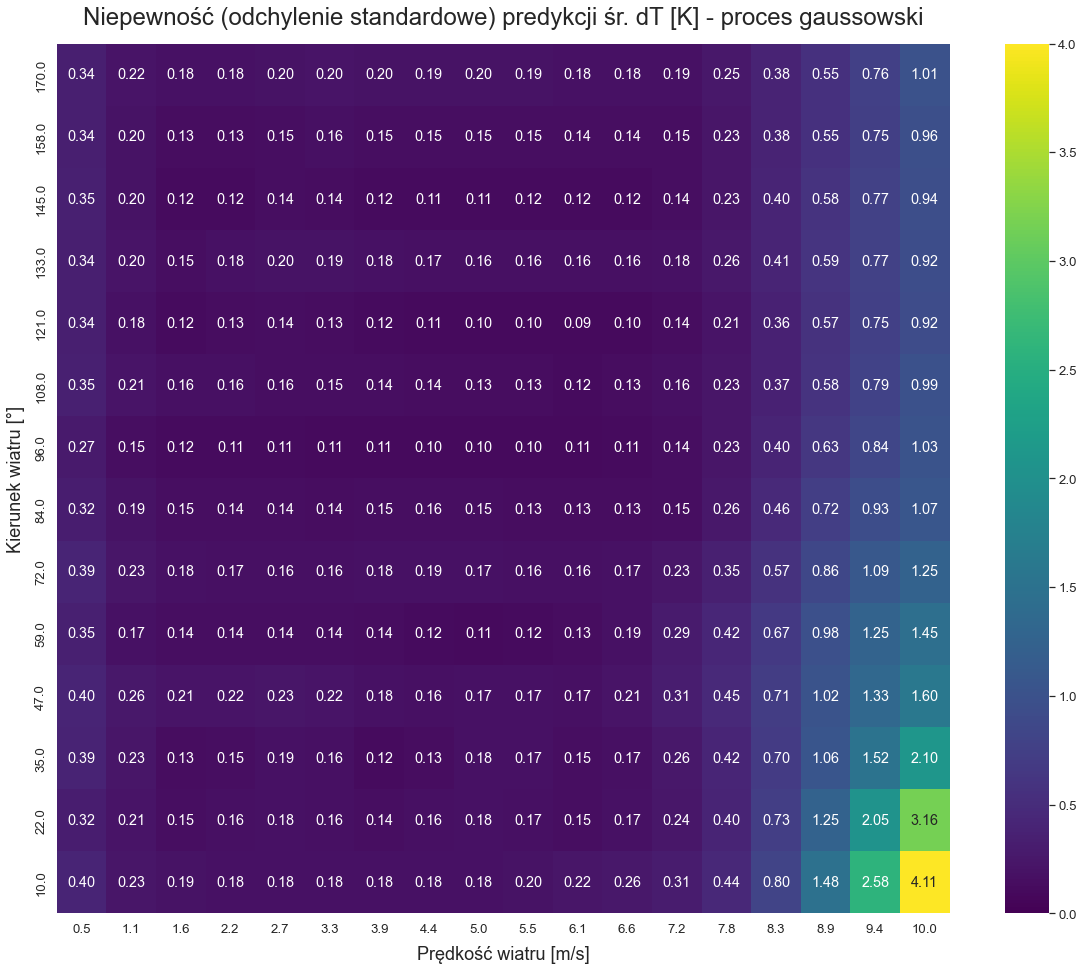

In [27]:
plt.figure(figsize=(20,16))
ax = sns.heatmap(sd_gp, vmin=0, vmax=4, annot=True, fmt='.2f', cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Niepewność (odchylenie standardowe) predykcji śr. dT [K] - proces gaussowski', fontsize=24, y=1.015)
ax.set_ylabel('Kierunek wiatru [\N{DEGREE SIGN}]', fontsize=18, labelpad=10)
ax.set_xlabel('Prędkość wiatru [m/s]', fontsize=18, labelpad=10)